# Data Exploration

Let's explore the data scrapped from [e-newspapersarchives.ch](https://www.e-newspaperarchives.ch/?a=p&p=home&e=-------fr-20--1--txt-txIN-+e-------0--fr---).

Quick reminder before starting: `articles.csv` contains all articles found on the aforementionned website that contain the world "écologie" (accent sensitive). The file contains several informations about the retrieved articles:
- *Article Title*: the header of the article
- *Journal*: name of the newspaper in which it was published
- *Date*: date of publication (in french, format: DAY mois YEAR, eg. 10 septembre 1992)
- *Url*: url link to the article
- *Text*: OCR text from the article

In [1]:
# import basic packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
# import package to parse date from str to datetime format
try:
    import dateparser
except:
    !pip install dateparser
    import dateparser

In [3]:
# store the dataset into a Pandas DataFrame and parse the date
articles = pd.read_csv("articles.csv", parse_dates=['Date'], date_parser=dateparser.parse)
n_before = len(articles) # number of articles in the DF
articles.sample(5)

,Unnamed: 0,Article Title,Journal,Date,Url,Text
1001,1,VILLE DE FRIBOURG,La Liberté,1988-09-28,https://www.e-newspaperarchives.ch/?a=d&d=LLE1...,"VILLE DE FRIBOURG Lundi soir , pendant sa sé..."
1491,11,BALADE. Longue marche hivernale en montagne et...,Construire,1997-01-08,https://www.e-newspaperarchives.ch/?a=d&d=MIG1...,BALADE Longue marche hivernale en montagne e...
1365,5,FRIBOURG Six «ateliers» traiteront de l'...,La Liberté,1993-03-30,https://www.e-newspaperarchives.ch/?a=d&d=LLE1...,FRIBOURG Six « ateliers » traiteront de lécon...
1111,11,UNES IES LIBRES LIBRES Cé INMAS L'AL à L...,Chablais Magazine,2000-12-12,https://www.e-newspaperarchives.ch/?a=d&d=CHM2...,UNES IES LIBRES LIBRES Cé INMAS LAL à La Bern...
1237,17,LA LIBERTE 12 JEUDI 28 AOÛT 2003 | Une e...,La Liberté,2003-08-28,https://www.e-newspaperarchives.ch/?a=d&d=LLE2...,LA LIBERTE 12 JEUDI 28 AOÛT 2003 | Une entrep...


In [4]:
# drop rows (=articles) with missing informations
articles = articles.dropna().reset_index()
print("{0} rows with NaN dropped, {1} articles remaining in the DF.".format(n_before-len(articles), len(articles)))

5 rows with NaN dropped, 2805 articles remaining in the DF.


## Distribution over time

Let's first look at the number of articles retrieved per year.

TODO:
- [ ] find the total number of articles per year on the website to normalize

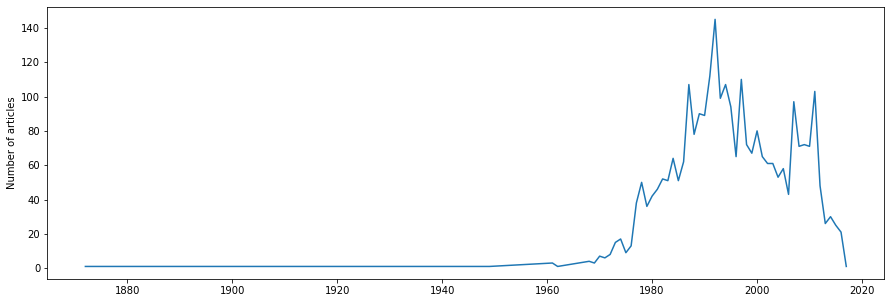

In [5]:
# number of articles per year
articles_per_year = articles.groupby(articles.Date.dt.year).count().Url

# plot the timeserie
fig, ax = plt.subplots(figsize=(15,5))

ax.plot(articles_per_year)

plt.ylabel('Number of articles')

plt.show()

From the above plot, one can already see that this term began to be used in the late 60s/early 70s and peaked around 1990 and a second, less important, peak happened around 2010.

In [6]:
print("The year with the most articles containing 'écologie' is {0}, with {1} articles.\
".format(articles_per_year.keys()[articles_per_year == np.max(articles_per_year)][0], np.max(articles_per_year)))

The year with the most articles containing 'écologie' is 1992, with 145 articles.


In [7]:
print("Only {0} articles were found before 1960.".format(len(articles[articles.Date.dt.year<1970])))

Only 17 articles were found before 1960.


Grouping the articles by decade

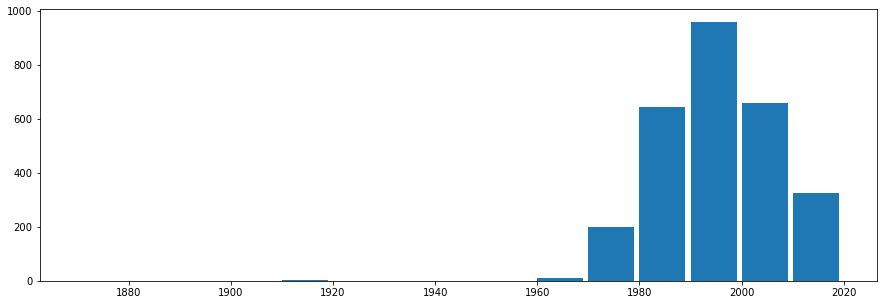

In [8]:
articles_per_decade = articles.groupby((articles.Date.dt.year//10)*10).count().Url

plt.figure(figsize=(15,5))
plt.bar(articles_per_decade.index
        , articles_per_decade
        , width=9
        , align='edge'
       )
plt.show()

Such a grouping makes the 2010's peak disappear as it was centered around 2010 (from late 2000s to early 2010s).

More than an absolute count of the number of articles containing the word 'écologie', it is important to assess its relative importance compared with the total number of articles present in the database of the scrapped website in order to check if the peaks are not "artificial" as they could just be reflecting years with more articles in the database. 

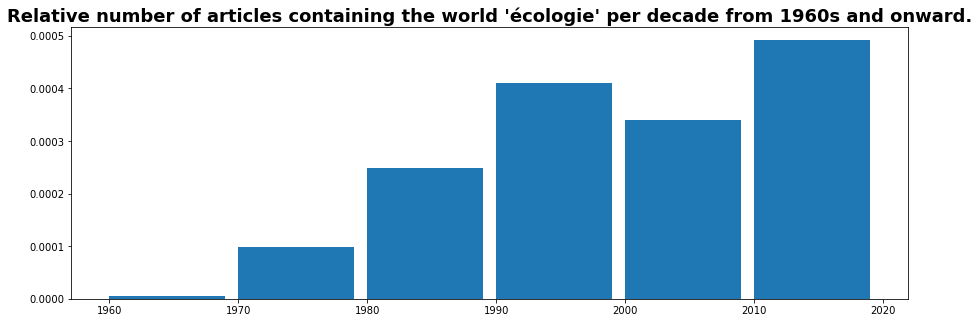

In [9]:
# total number of french articles on e-newspaperarchives.ch manually scrapped from 1960s to 2010s
tot_articles_per_decade = np.array([2138059, 2023171, 2580757, 2340471, 1948820, 660912])
rel_articles_per_decade_60 = articles_per_decade[articles_per_decade.keys() > 1955]/tot_articles_per_decade

plt.figure(figsize=(15,5))
plt.bar(rel_articles_per_decade_60.index
        , rel_articles_per_decade_60
        , width=9
        , align='edge'
       )

plt.title(
    "Relative number of articles containing the world 'écologie' per decade from 1960s and onward."
    , weight='semibold'
    , fontsize = 18
)

plt.show()

In [10]:
# scrapping test
import requests
from bs4 import BeautifulSoup

# make our scraper look like a legitimate browser
headers = {
    'Access-Control-Allow-Origin': '*',
    'Access-Control-Allow-Methods': 'GET',
    'Access-Control-Allow-Headers': 'Content-Type',
    'Access-Control-Max-Age': '3600',
    'User-Agent': 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:52.0) Gecko/20100101 Firefox/52.0'
    }

In [11]:
# if file already stored, load it, else scrap data
try:
    tot_n_articles = np.load("tot_n_articles.pkl", allow_pickle=True)
except:
    # initialization 
    years = range(1960, 2017)
    tot_n_articles = pd.Series(index=years, dtype=int)
    # retrieving the total number of articles (in french) per year based on the search of articles containing: ' '
    for y in years:
        url_curr = url_year = "https://www.e-newspaperarchives.ch/?a=q&hs=1&r=1&results=1&txq=%27+%27&dafdq=&dafmq=&dafyq="+str(y)+"&datdq=&datmq=&datyq="+str(y)+"&laq=fr&puq=&txf=txIN&ssnip=img&ccq=&e=-------fr-20--1--img-txIN-%27+%27-ARTICLE------0--fr---"

        req = requests.get(url_curr, headers)
        soup = BeautifulSoup(req.content, 'html.parser')
        header = soup.find_all("title")[0].text.replace("— e-newspaperarchives.ch", "") # eg. Résultats 1 - 20 de  186,326 pour ' '

        tot_n_articles[y] = np.int(header[21:28].replace(",","")) # convert the number of found articles from str to int

    # save it to a pickle file
    tot_n_articles.to_pickle("tot_n_articles.pkl")

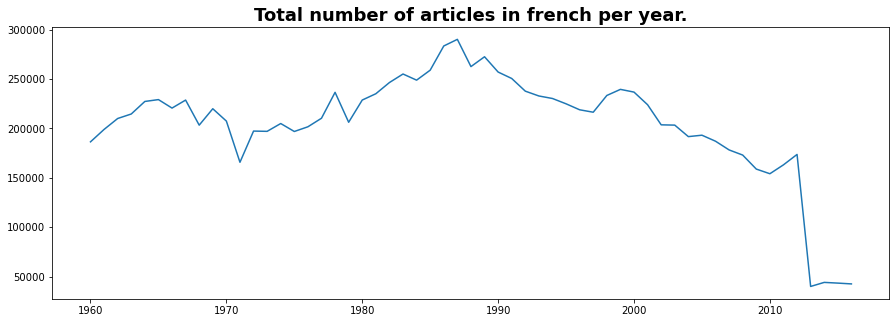

In [12]:
# plot the number of articles per year on the database:
fig, ax = plt.subplots(figsize=(15,5))

ax.plot(tot_n_articles)

plt.title(
    "Total number of articles in french per year."
    , weight='semibold'
    , fontsize = 18
)

plt.show()

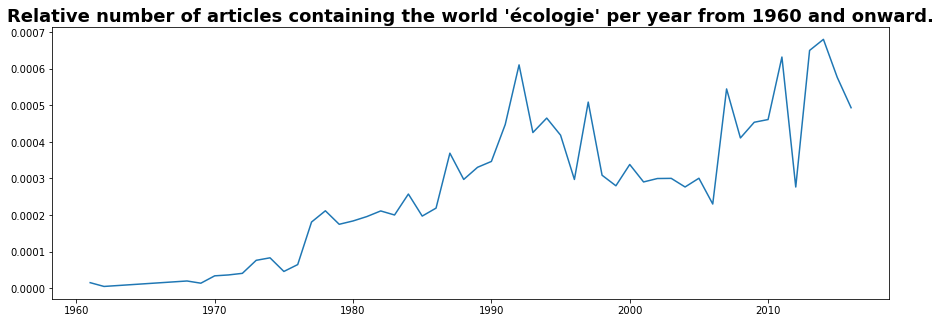

In [13]:
# plot the timeserie of relative number of articles per year
fig, ax = plt.subplots(figsize=(15,5))

ax.plot((articles_per_year[articles_per_year.index>1959]/tot_n_articles).dropna())

plt.title(
    "Relative number of articles containing the world 'écologie' per year from 1960 and onward."
    , weight='semibold'
    , fontsize = 18
)

plt.show()

++ we can see a strange pattern by month (if significant?)

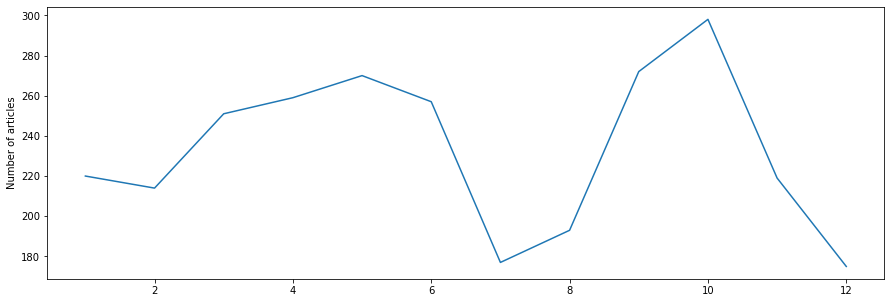

In [14]:
fig, ax = plt.subplots(figsize=(15,5))

ax.plot(articles.groupby(articles.Date.dt.month).count().Url)

plt.ylabel('Number of articles')

plt.show()

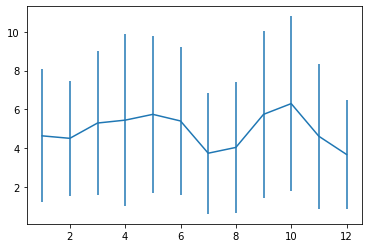

In [15]:
y_m_articles = articles[articles.Date.dt.year>1970].groupby([articles.Date.dt.year, articles.Date.dt.month]).count().Url
y_m_articles.index.set_names(["Year", "Month"], inplace=True)
mean_m_articles = y_m_articles.unstack().fillna(0).stack().reset_index().groupby('Month').mean()[0]
std_m_articles = y_m_articles.unstack().fillna(0).stack().reset_index().groupby('Month').std()[0]

plt.errorbar(mean_m_articles.index, mean_m_articles, yerr=std_m_articles)
plt.show()
# seems not really significant all in all

## Distribution over newspaper editors

Let's then study the diversity of the corpus in term of the distribution of the articles over different newspaper editors.

In [16]:
n_journaux = articles.groupby(articles.Journal).count().Url.sort_values()
print("The dataset contains articles from {0} editors.".format(len(n_journaux)))

The dataset contains articles from 23 editors.


Let's have a look at the number of articles per editor:

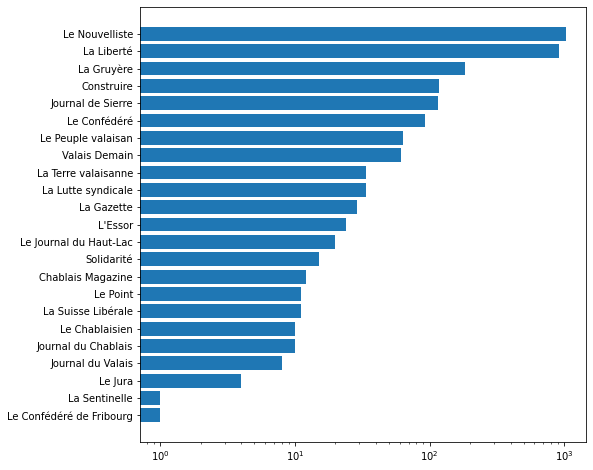

In [17]:
plt.figure(figsize=(8,8))
plt.barh(n_journaux.keys(), n_journaux)
plt.semilogx()
plt.show()

One can see from the above plot that the dataset is largely dominated by two editors, namely *Le Nouvelliste* and *La Liberté*.

In [18]:
print("The two most represented editors have published {0:.2f}% of all the articles present in the dataset.\
".format(100*(n_journaux[-1]+n_journaux[-2])/n_journaux.sum()))

The two most represented editors have published 69.52% of all the articles present in the dataset.


## Editors' time

Let's put both of the precedently studied features together now by exporing the evolution of the presence of the editors. As seen before, two editors are much more in the dataset, we will then rearrange the DF for this part of the exploration. Instead of the name of the newspaper, all articles that are not published in one of the two top editors will appear has published in *Others*.

In [19]:
top_editors = np.array(n_journaux.keys()[-2:])
articles_top_others = articles.copy()
articles_top_others["Journal"] = [j if j in top_editors else "Others" for j in articles_top_others["Journal"]]

In [20]:
# number of articles per journal per year
evol_year_top_others = articles_top_others[articles_top_others.Date.dt.year>1960].groupby([articles_top_others.Date.dt.year, "Journal"]).count().Url.unstack().fillna(0)
# normalization over the year (for each year --> sum to 1)
evol_year_top_others_norm = evol_year_top_others.div(evol_year_top_others.sum(axis=1), axis=0)

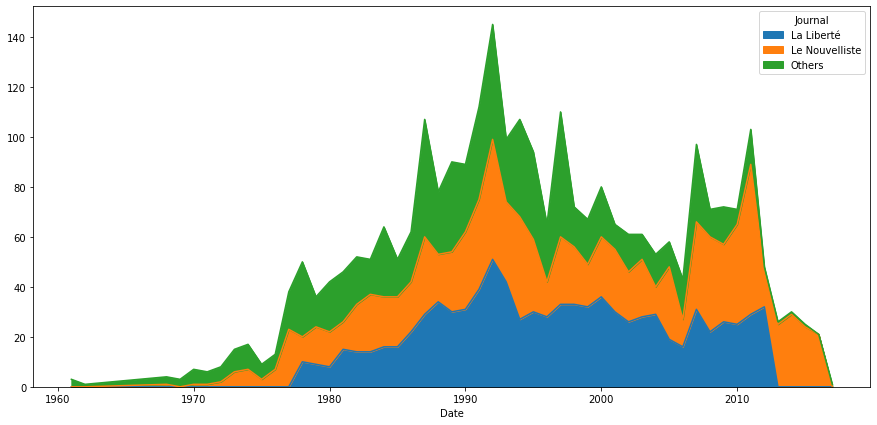

In [21]:
fig, axis = plt.subplots(figsize=(15,7))
ax = evol_year_top_others.plot.area(ax=axis)
plt.show()

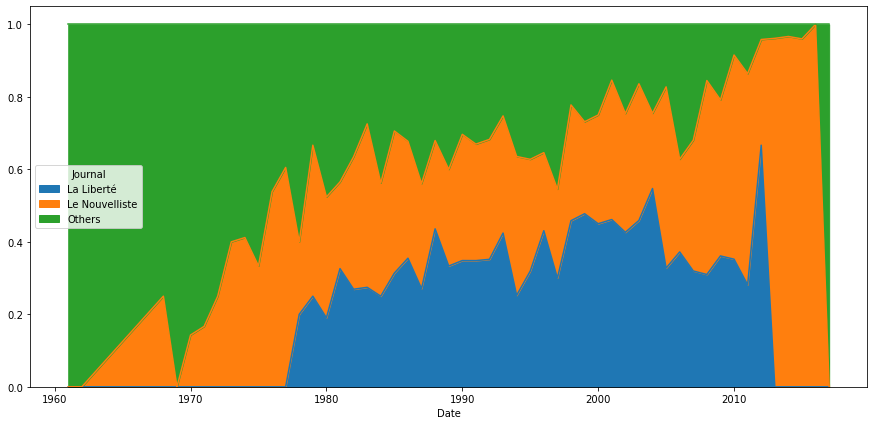

In [22]:
fig, axis = plt.subplots(figsize=(15,7))
ax = evol_year_top_others_norm.plot.area(ax=axis)
plt.show()

The same analysis can be lead on decades:

In [23]:
decade_top_others = articles_top_others[(articles_top_others.Date.dt.year//10)*10 >1955].groupby([(articles_top_others.Date.dt.year//10)*10, "Journal"]).count().Url.unstack().fillna(0)
decade_top_others

Journal,La Liberté,Le Nouvelliste,Others
Date,,,
1960,0.0,1.0,10.0
1970,19.0,75.0,105.0
1980,198.0,201.0,244.0
1990,346.0,298.0,316.0
2000,263.0,247.0,151.0
2010,86.0,213.0,26.0


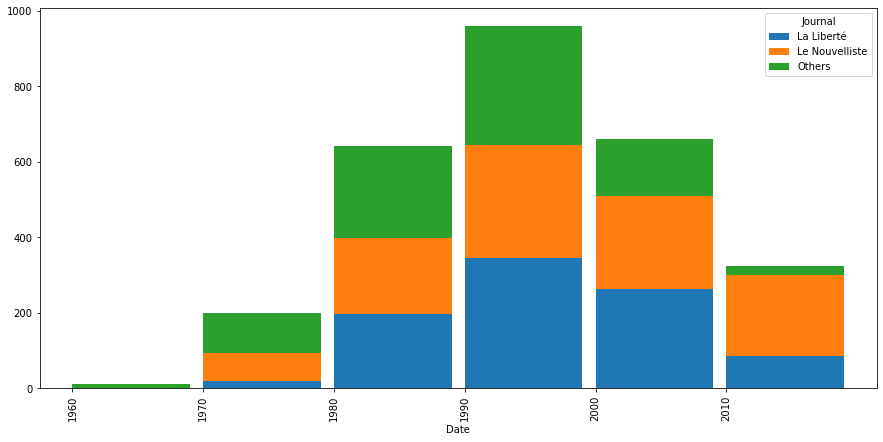

In [24]:
fig, axis = plt.subplots(figsize=(15,7))
decade_top_others.plot.bar(stacked=True, align='edge', ax=axis, width=0.9)
plt.show()

## What's in those articles ?

We can now try to see what the article contain.

We can begin by printing the content of a random article of the dataset:

In [25]:
# it is sometimes really weird
print(articles.iloc[np.int(np.random.random()*len(articles))].Text)

 L université du Chablais informe  Depuis une semaine , les animateurs bénévoles de lUPC ont la joie d ouvrir le premier cycle de cours , prévus avant Noël . Un tel agencement implique toute une série de problèmes pratiques tels que pourvoir aux nécessités matérielles essentielles : locaux , tableaux noirs etc . La part des communes est grande et déjà nous avons le plaisir de remarquer que des contacts fructueux sont nés depuis la miseptembre . Vionnaz subventionne lUPC et offre ses locaux ; Evionnaz incite sa commission culturelle à étudier sa participation ; la municipalité de Bex met à disposition de lUPC une salle de cours ; Gryon sintéresse également aux visées culturelles en matière déducation permanente des adultes tout comme le Département de linstruction publique du canton de Vaud qui vient de prendre en considération pour étude la demande de lUPC . Dans un avenir proche , dautres communes du Chablais vaudois et valaisan ne devraient pas tarder à joindre leurs efforts à la pro

Let's have a look at the distribution of the number of characters among all articles of the dataset:

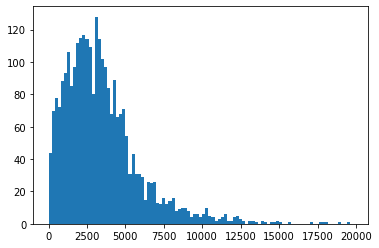

In [26]:
bins = np.arange(0, 20000, 200)
hist_nb_char, bin_edges, patches = plt.hist([len(articles.Text[i]) for i in range(len(articles))], bins=bins)